In [1]:
import pandas as pd
import pyranges as pr
from glob import glob
import seaborn as sns
import os
from statannotations.Annotator import Annotator

In [2]:
quantseqGroups = pd.read_csv('../../results/GeneGroups_Quantseq/KO_WT_GeneGroups_TPMGreaterThan5InEitherCondition_NaiveExemption_MinUtrLen100.csv', index_col=0)
quantseqGroups.index.name = 'stable_id'
quantseqGroups.reset_index(inplace=True)

utrAtlas = pr.read_bed('../../data/3UtrAtlas/ThreePrimeUtrsOfMostExpressedTxInS200WT2iL.bed', as_df=True)

outpath = '../../results/GeneGroups_Quantseq/3UtrLoci/'
os.makedirs(outpath, exist_ok=True)

In [3]:
quantseqGroups.head()

,stable_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,regulation,Naive_Genes,UtrLength,Mean TPM in KO FCL,Mean TPM in S200WT FCL
0,ENSMUSG00000019989,100.502061,-6.899042,1.187189,2.131607e-12,2.851307e-10,significant,DOWN,NaN,1499.0,6.805262,0.029012
1,ENSMUSG00000067261,66.277383,-5.904965,1.336151,1.960311e-08,8.695607e-07,significant,DOWN,naive,591.0,16.837129,0.368562
2,ENSMUSG00000025056,404.741076,-5.527307,1.179705,1.669016e-07,5.224981e-06,significant,DOWN,NaN,355.0,92.916880,1.507541
3,ENSMUSG00000022385,437.435334,-4.238394,1.281661,3.702637e-05,4.734508e-04,significant,DOWN,NaN,344.0,29.267134,0.783639
4,ENSMUSG00000021765,81.029489,-4.188287,1.694878,6.187344e-04,4.393512e-03,significant,DOWN,NaN,1516.0,13.895529,0.276672


In [4]:
# Get stable gene id
utrAtlas['stable_id'] = utrAtlas.Name.apply(lambda x: x.split('.')[0])

In [5]:
utrAtlas.head()

,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd,stable_id
0,chr11,101336310,101336355,ENSMUSG00000063316,14305.195725,+,Rpl27,ENSMUST00000127514,ENSMUSG00000063316
1,chr10,23661799,23661902,ENSMUSG00000061983,10290.644582,-,Rps12,ENSMUST00000218142,ENSMUSG00000061983
2,chr7,45370210,45370254,ENSMUSG00000059070,9195.800582,+,Rpl18,ENSMUST00000209556,ENSMUSG00000059070
3,chr12,69204495,69204589,ENSMUSG00000034892,8985.798328,-,Rps29,ENSMUST00000037023,ENSMUSG00000034892
4,chr10,128383982,128384258,ENSMUSG00000093674,8954.904355,-,Rpl41,ENSMUST00000176683,ENSMUSG00000093674


In [6]:
quantseqGroups = quantseqGroups.merge(utrAtlas, on='stable_id', how='left')
quantseqGroups.head()

,stable_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,regulation,Naive_Genes,UtrLength,Mean TPM in KO FCL,Mean TPM in S200WT FCL,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd
0,ENSMUSG00000019989,100.502061,-6.899042,1.187189,2.131607e-12,2.851307e-10,significant,DOWN,NaN,1499.0,6.805262,0.029012,chr10,24648303,24649802,ENSMUSG00000019989,0.000000,-,Enpp3,ENSMUST00000020169
1,ENSMUSG00000067261,66.277383,-5.904965,1.336151,1.960311e-08,8.695607e-07,significant,DOWN,naive,591.0,16.837129,0.368562,chr4,99546268,99546859,ENSMUSG00000067261,9.151346,+,Foxd3,ENSMUST00000087285
2,ENSMUSG00000025056,404.741076,-5.527307,1.179705,1.669016e-07,5.224981e-06,significant,DOWN,NaN,355.0,92.916880,1.507541,chrX,85239198,85239553,ENSMUSG00000025056,16.841865,+,Nr0b1,ENSMUST00000026036
3,ENSMUSG00000022385,437.435334,-4.238394,1.281661,3.702637e-05,4.734508e-04,significant,DOWN,NaN,344.0,29.267134,0.783639,chr15,85760430,85760774,ENSMUSG00000022385,11.593847,+,Gtse1,ENSMUST00000231074
4,ENSMUSG00000021765,81.029489,-4.188287,1.694878,6.187344e-04,4.393512e-03,significant,DOWN,NaN,1516.0,13.895529,0.276672,chr13,114588825,114590341,ENSMUSG00000021765,0.116167,-,Fst,ENSMUST00000223640


In [7]:
# Remove NaN entries
quantseqGroups = quantseqGroups.loc[quantseqGroups.Chromosome.notna()]

In [8]:
# How many genes do we have now?
quantseqGroups.groupby('regulation').count()['stable_id']

regulation
CONTROL    2705
DOWN       1183
UP          988
Name: stable_id, dtype: int64

In [9]:
# Convert to bed format
quantseqGroupsBed = quantseqGroups[['Chromosome', 'Start', 'End', 'regulation', 'log2FoldChange', 'Strand', 'stable_id']]
quantseqGroupsBed[['Start', 'End']] = quantseqGroupsBed[['Start', 'End']].astype(int)
# Save
quantseqGroupsBed.loc[quantseqGroupsBed.regulation.notna()].to_csv(f'{outpath}/QuantseqGroups.bed', quoting=None, header=None, index=False, sep='\t')
quantseqGroups.to_csv(f'{outpath}/QuantseqGroups_WithStatisticsAnd3Utrs.csv')

/home/klara/anaconda3/envs/JupyterAnalyses/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


DOWN vs. CONTROL: Welch's t-test independent samples, P_val:6.174e-01 t=-4.996e-01
DOWN vs. UP: Welch's t-test independent samples, P_val:2.704e-01 t=-1.102e+00


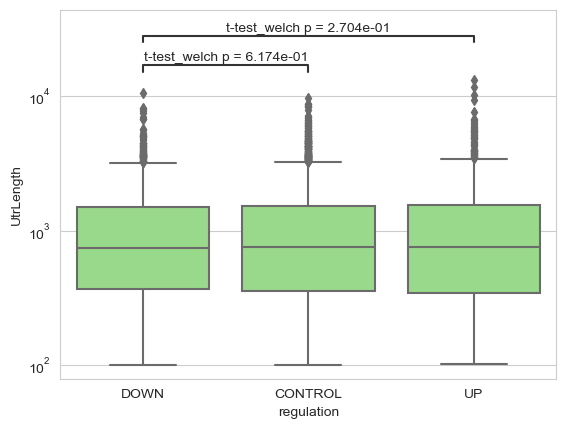

In [10]:
# Compare lengths
sns.set_style("whitegrid")
dfPlot = quantseqGroups.copy()
g = sns.boxplot(data = dfPlot, x='regulation', y='UtrLength', color='#99d98c', saturation=1, order=["DOWN", "CONTROL", "UP"])
g.set_yscale('log')
annot = Annotator(g, pairs=[("DOWN", "CONTROL"), ("DOWN", "UP")],\
                data=dfPlot, x="regulation", y="UtrLength", order=["DOWN", "CONTROL", "UP"])
annot.configure(test='t-test_welch', text_format='full', loc='inside', verbose=2)
annot.apply_test().annotate()

g.figure.savefig(f'{outpath}/LengthComparisonLogScale.pdf', bbox_inches='tight')

With quantseq groups we don't see any differences in 3'UTR length. Perhaps this is telling us that slamseq results are very inpacted by 3'UTR length and that length was a primary factor that impacted group formation.

## Save 3UTRs of naive genes in a bed format and for ClipPlotR

In [11]:
NaiveUtrs = quantseqGroups.loc[quantseqGroups.Naive_Genes == 'naive']
NaiveUtrs.head()

,stable_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,regulation,Naive_Genes,UtrLength,Mean TPM in KO FCL,Mean TPM in S200WT FCL,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd
1,ENSMUSG00000067261,66.277383,-5.904965,1.336151,1.960311e-08,8.695607e-07,significant,DOWN,naive,591.0,16.837129,0.368562,chr4,99546268,99546859,ENSMUSG00000067261,9.151346,+,Foxd3,ENSMUST00000087285
26,ENSMUSG00000055148,1141.886927,-3.097026,0.312118,2.126287e-24,2.895577e-21,significant,DOWN,naive,740.0,195.615277,24.000822,chr8,73074760,73075500,ENSMUSG00000055148,218.084354,+,Klf2,ENSMUST00000067912
44,ENSMUSG00000012396,735.336172,-2.677221,0.526324,2.981861e-08,1.241804e-06,significant,DOWN,naive,1081.0,45.130223,6.660679,chr6,122690511,122691592,ENSMUSG00000012396,112.513193,+,Nanog,ENSMUST00000112580
73,ENSMUSG00000040943,168.432928,-2.309082,0.486423,2.064421e-07,6.192354e-06,significant,DOWN,naive,3061.0,3.156284,0.738586,chr3,133169439,133172500,ENSMUSG00000040943,1.003445,-,Tet2,ENSMUST00000098603
87,ENSMUSG00000053470,320.395727,-2.231270,0.452762,1.100491e-07,3.646693e-06,significant,DOWN,naive,666.0,9.215087,1.836670,chr6,71565955,71566621,ENSMUSG00000053470,5.463655,-,Kdm3a,ENSMUST00000065509


In [12]:
# Convert to bed format and save
NaiveUtrs[['Start', 'End']] = NaiveUtrs[['Start', 'End']].astype(int)
NaiveUtrs['Score'] = '.'
NaiveUtrs[['Chromosome', 'Start', 'End', 'ThickStart', 'Score', 'Strand', 'Name', 'regulation']].to_csv(f'{outpath}/NaiveGenesUtrs.bed', sep='\t', header=None, index=False, quoting=None)

/home/klara/anaconda3/envs/JupyterAnalyses/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/klara/anaconda3/envs/JupyterAnalyses/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Get ClipplotR format: Tcf7l1,chr6:72603353:72604342:-

In [16]:
# Remove file if it exists
if os.path.exists(f'{outpath}/NaiveGenes_ClipplotR.txt'):
    os.remove(f'{outpath}/NaiveGenes_ClipplotR.txt')
# Generate it
with open(f'{outpath}/NaiveGenes_ClipplotR.txt', 'w') as f:
    for i, row in NaiveUtrs.iterrows():
        line = f'naiveGene_{row.ThickStart}_{row.stable_id}_{row.regulation},{row.Chromosome}:{row.Start - 20}:{row.End + 20}:{row.Strand}\n'
        f.writelines(line)